## PREDICTING HOUSING PRICES IN KING COUNTY

King County Real-Estate is trying to predict home prices for their clients. The aim of this project is to learn more about their county's home prices and the features that affect home prices. We build linear regression models to accurately predict the price of homes in their county. This would be useful to King County homeowners who are looking to sell their home in order to get an idea of their home's value before deciding to list it with a realtor.

#### IMPORT LIBRARIES AND DATA

In [74]:
# importing the necessary libraries
import itertools
import pandas as pd
import numpy as np
import json
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
%matplotlib inline

import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the data
df = pd.read_csv('../data/kc_house_data.csv')
#previewing the data
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


#### DATA CLEANING

Assigning new variable to the relevant variables

In [3]:
df['date'].sort_values()

12076    1/10/2015
19359    1/12/2015
2548     1/12/2015
18398    1/12/2015
11086    1/12/2015
           ...    
19256     9/9/2014
66        9/9/2014
20288     9/9/2014
12438     9/9/2014
15702     9/9/2014
Name: date, Length: 21597, dtype: object

In [4]:
df.date =  pd.to_datetime(df.date, format='%m/%d/%Y')

In [5]:
df.waterfront.value_counts()

waterfront
0.0    19075
1.0      146
Name: count, dtype: int64

In [6]:
df['waterfront'] = df['waterfront'].fillna(value=0.0)

In [7]:
df.view.value_counts()

view
0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: count, dtype: int64

In [8]:
df = df.dropna(subset=['view'])

In [9]:
df.yr_renovated.value_counts()

yr_renovated
0.0       16961
2014.0       73
2013.0       31
2003.0       31
2007.0       30
          ...  
1951.0        1
1953.0        1
1946.0        1
1976.0        1
1948.0        1
Name: count, Length: 70, dtype: int64

In [10]:
df['yr_renovated'] = df['yr_renovated'].fillna(value=0.0)

In [11]:
df.shape

(21534, 21)

In [12]:
df.sqft_basement.value_counts()

sqft_basement
0.0       12798
?           452
600.0       216
500.0       209
700.0       207
          ...  
3480.0        1
1840.0        1
2730.0        1
2720.0        1
248.0         1
Name: count, Length: 302, dtype: int64

In [13]:
# assuming ? means no basement
df.sqft_basement = df.sqft_basement.replace('?', '0.0')

In [14]:
# getting counts for each value in condition column
df['condition'].value_counts()

condition
3    13981
4     5657
5     1697
2      170
1       29
Name: count, dtype: int64

In [15]:
#counts for each value in zipcode column
df['zipcode'].value_counts()

zipcode
98103    601
98038    586
98115    580
98052    573
98117    553
        ... 
98102    104
98010    100
98024     79
98148     57
98039     50
Name: count, Length: 70, dtype: int64

In [16]:
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement            object
yr_built                  int64
yr_renovated            float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [17]:
df.condition.replace({'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}, inplace=True)
df.grade.replace({'3 Poor': 0, '4 Low': 1, '5 Fair': 2, '6 Low Average': 3, '7 Average': 4, '8 Good': 5, 
                  '9 Better': 6, '10 Very Good': 7, '11 Excellent': 8, '12 Luxury': 9, '13 Mansion': 10}, 
                 inplace=True)

In [18]:
# Convert to float
df['sqft_basement'] = df['sqft_basement'].astype(float)

In [19]:
#checking for duplicates
duplicates = df[df.duplicated()]
print(len(duplicates))

0


In [20]:
df.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.153400e+04,21534,2.153400e+04,21534.000000,21534.000000,21534.000000,2.153400e+04,21534.000000,21534.000000,21534.000000,...,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000
mean,4.582351e+09,2014-10-29 01:53:20.780161536,5.400577e+05,3.373038,2.115712,2079.827854,1.509060e+04,1.494126,0.006734,0.233863,...,7.657425,1788.557537,285.244311,1971.002275,68.866722,98077.939352,47.560180,-122.213948,1986.299944,12751.079502
min,1.000102e+06,2014-05-02 00:00:00,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,...,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123212e+09,2014-07-22 00:00:00,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.328000,1490.000000,5100.000000
50%,3.904945e+09,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.617000e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,7.312175e+09,2015-02-17 00:00:00,6.450000e+05,4.000000,2.500000,2550.000000,1.068775e+04,2.000000,0.000000,0.000000,...,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678100,-122.125000,2360.000000,10083.000000
max,9.900000e+09,2015-05-27 00:00:00,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000
std,2.876779e+09,NaN,3.660596e+05,0.926410,0.768602,917.446520,4.138021e+04,0.539806,0.081783,0.765686,...,1.172643,827.745641,439.334095,29.376044,364.314552,53.506639,0.138528,0.140735,685.121001,27255.483308


In [21]:
df.loc[df['bedrooms'] > 15]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [22]:
# Getting rid of the house with 33 bedrooms and 1 bathroom (outlier)
df = df.loc[df['bedrooms'] < 15]

#### DATA ANALYSIS

In [23]:
df['yr_built'].value_counts().sort_values()

yr_built
1934     21
1935     24
1902     27
1901     29
1933     30
       ... 
2003    419
2004    430
2005    448
2006    453
2014    558
Name: count, Length: 116, dtype: int64

In [24]:
print(df.groupby('waterfront')['price'].count())
print(df.groupby('waterfront')['price'].mean())

waterfront
0.0    21388
1.0      145
Name: price, dtype: int64
waterfront
0.0    5.322400e+05
1.0    1.692506e+06
Name: price, dtype: float64


In [25]:
print(df.groupby('condition')['price'].count())
print(df.groupby('condition')['price'].mean())

condition
1       29
2      170
3    13981
4     5657
5     1696
Name: price, dtype: int64
condition
1    341067.241379
2    328178.758824
3    542226.410772
4    520432.244122
5    612221.544811
Name: price, dtype: float64


A heat map to show the correlation of each column to decide which features will be useful in our model

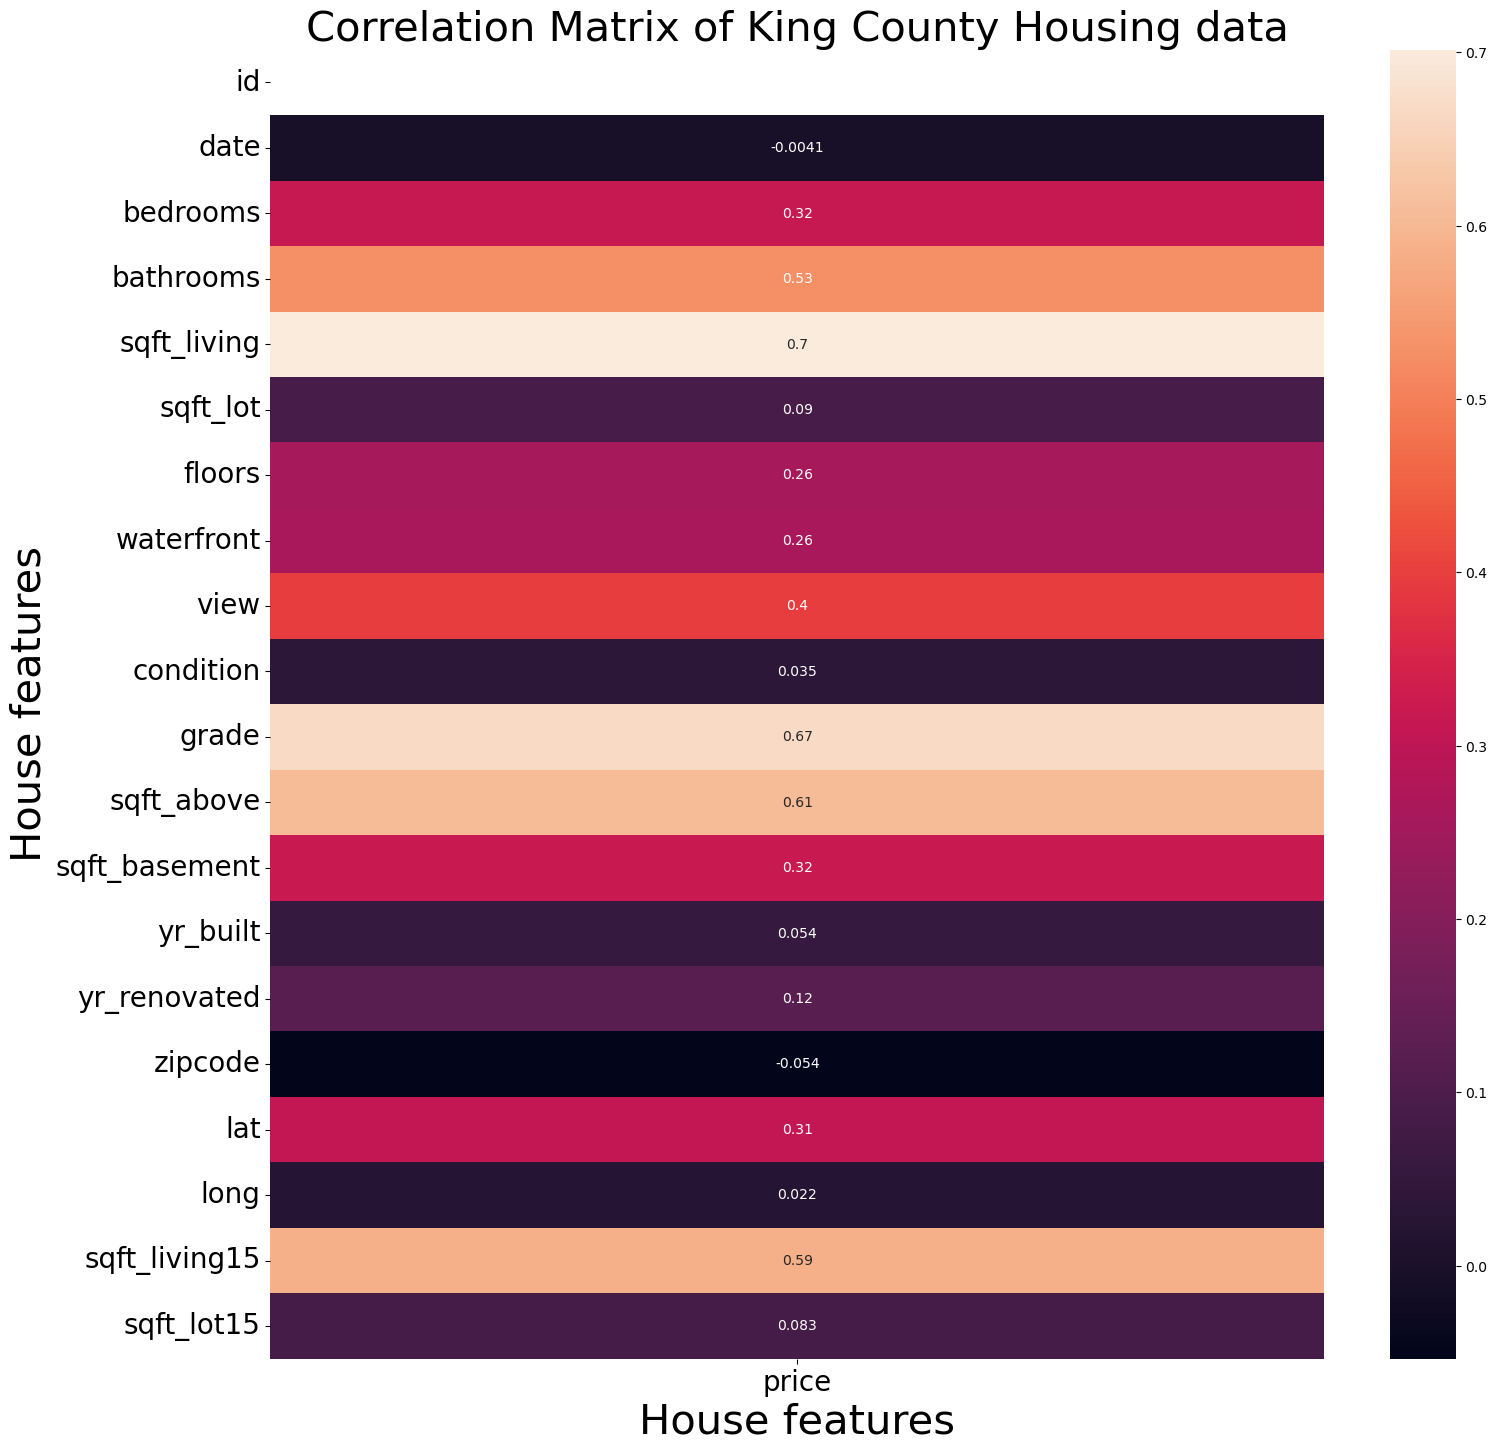

In [26]:
# correlation matrix with duplicated removed
corrMatrix = df.corr()[[column for column in df.columns if column== 'price']].drop(['price'])
matrix = np.triu(corrMatrix)

# plot correlation matrix in heat map with seaborn
fig, ax = plt.subplots(figsize=(17,17)) 
sns.heatmap(corrMatrix, annot=True, mask=matrix)

plt.title('Correlation Matrix of King County Housing data', size=30)
plt.xlabel('House features', size=30)
plt.ylabel('House features', size=30)
plt.xticks(size=20)
plt.yticks(size=20);

##### Effect of zipcode on price

In [27]:
# Figure out the unique zipcodes
print(df['zipcode'].nunique())
df['zipcode'].unique()

70


array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98146, 98038,
       98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133, 98040,
       98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058, 98001,
       98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008, 98059,
       98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010, 98118,
       98199, 98032, 98045, 98102, 98077, 98198, 98108, 98168, 98177,
       98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011, 98031,
       98106, 98072, 98188, 98065, 98014, 98055, 98039], dtype=int64)

In [28]:
# Zipcodes with the highest mean house prices
highest_price_zipcode = pd.DataFrame(df.groupby('zipcode')['price'].agg('mean').sort_values(ascending=False).head(10))

highest_price_zipcode = highest_price_zipcode.reset_index()

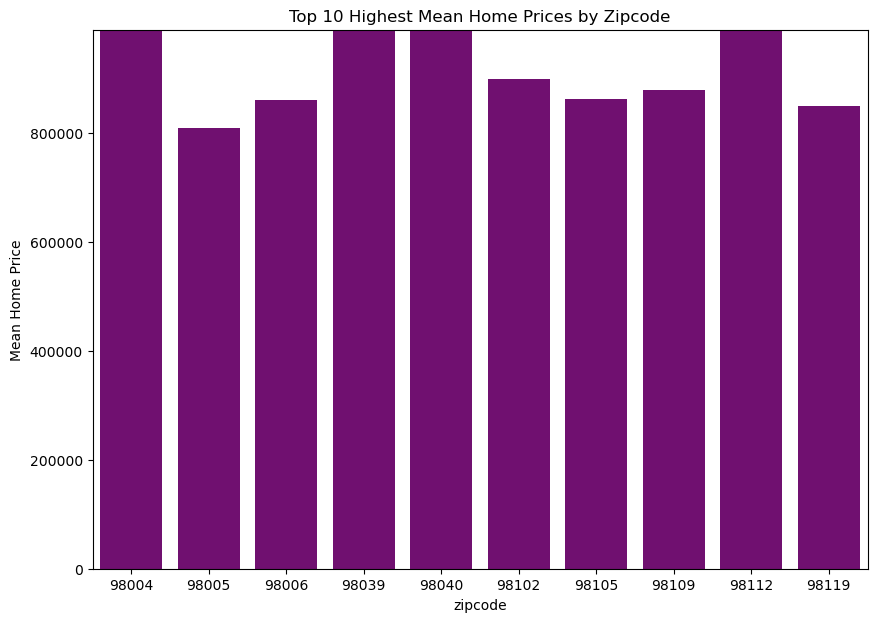

In [29]:
# Plot the top 10
fig = plt.figure(figsize=(10,7))
x = highest_price_zipcode.zipcode
y = highest_price_zipcode.price
sns.barplot(x=x, y=y, color = "purple")
plt.title('Top 10 Highest Mean Home Prices by Zipcode')
plt.ylim(0, 990000)
plt.ylabel('Mean Home Price')
plt.show()

In [30]:
#Next we look at zipcodes with the lowest mean house prices
lowest_price_zipcode = pd.DataFrame(df.groupby('zipcode')['price'].mean().sort_values(ascending=True).head(10))
lowest_price_zipcode = lowest_price_zipcode.reset_index()

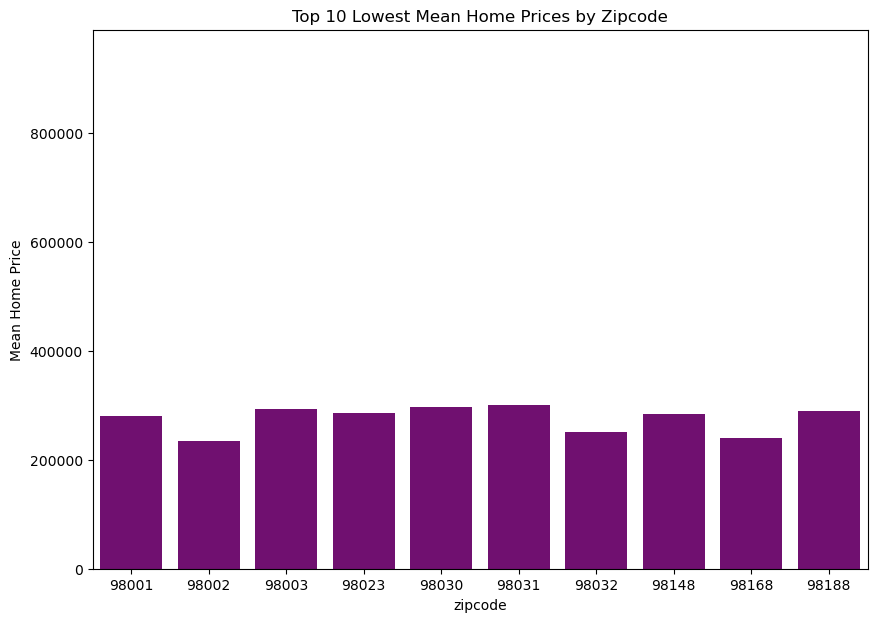

In [31]:
# Plot the lowest 10
fig = plt.figure(figsize=(10,7))
x1 = lowest_price_zipcode.zipcode
y1 = lowest_price_zipcode.price
sns.barplot(x=x1, y=y1, color = "purple")
plt.title('Top 10 Lowest Mean Home Prices by Zipcode')
plt.ylim(0, 990000)
plt.ylabel('Mean Home Price')
plt.show()

From the bar plots, we figure out which of the top 10 highest mean price zipcodes are waterfront houses

In [32]:
waterfront_zip = df.groupby(['waterfront', 'zipcode']).agg(mean_price =("price",'mean'))
waterfront_zip = waterfront_zip.reset_index()

In [33]:
waterfront_zip = waterfront_zip.loc[waterfront_zip['zipcode'].isin(x)]
waterfront_zip

,waterfront,zipcode,mean_price
3,0.0,98004,1.340423e+06
4,0.0,98005,8.102897e+05
5,0.0,98006,8.543396e+05
24,0.0,98039,2.131122e+06
25,0.0,98040,1.123611e+06
41,0.0,98102,8.996077e+05
43,0.0,98105,8.341568e+05
47,0.0,98109,8.800778e+05
48,0.0,98112,1.094695e+06
53,0.0,98119,8.497148e+05


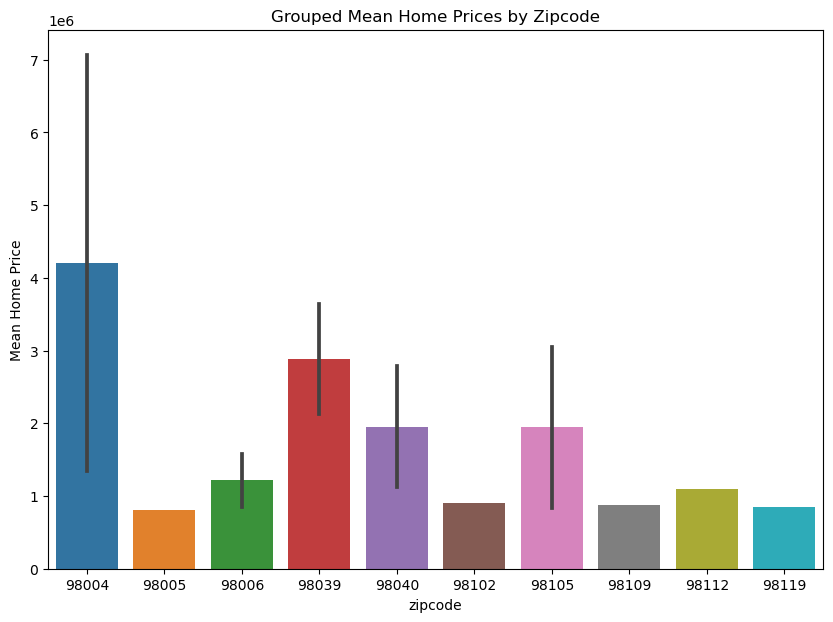

In [34]:
# From the information above we can tell that 5 of these houses are waterfront houses
fig = plt.figure(figsize=(10,7))
sns.barplot(x='zipcode', y='mean_price', data=waterfront_zip)
plt.title('Grouped Mean Home Prices by Zipcode')
plt.ylabel('Mean Home Price')
plt.show()

##### Next we check to see if any of the houses in the top 10 lowest mean price zipcodes are waterfront houses

In [35]:
waterfront_zip2 = waterfront_zip.loc[waterfront_zip['zipcode'].isin(x1)]
waterfront_zip2

# None of the houses are waterfront houses

,waterfront,zipcode,mean_price


##### Next we look at all the waterfront houses to see where the highest mean prices are

In [36]:
waterfront_df = df.loc[df['waterfront'] == 1]

waterfront_zipcode = pd.DataFrame(waterfront_df.groupby('zipcode')['price'].mean().sort_values(ascending=False). head(10))
waterfront_zipcode = waterfront_zipcode.reset_index()

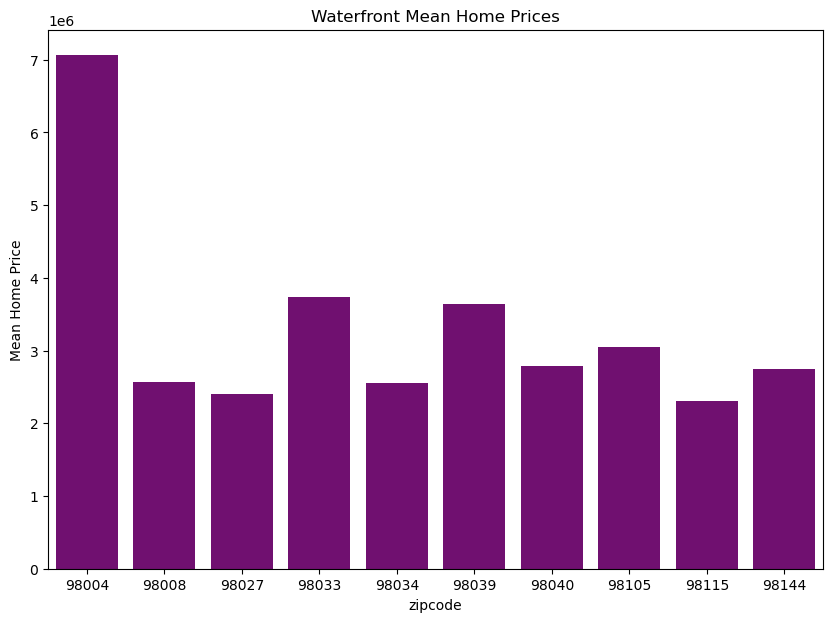

In [37]:
fig = plt.figure(figsize=(10,7))
x2 = waterfront_zipcode.zipcode
y2 = waterfront_zipcode.price
sns.barplot(x=x2, y=y2, color = "purple")
plt.title('Waterfront Mean Home Prices')
plt.ylabel('Mean Home Price')
plt.show()

From the bar plot above, the zipcodes with the highest mean prices are 98004, 98033 & 98039. Out of these three, two have waterfront houses. From the data and bar plots, the conclusion is that waterfront houses are more expensive however, not all of the highest-priced neighborhoods contain waterfront houses. 
This means there are other features that contribute to the prices of these houses.

Another feature we can explore is the effect of lot square footage and living square footage on the prices of these houses.

In [38]:
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,0.0,1995,0.0,98003,47.3097,-122.327,2238,6819
8,2414600126,2015-04-15,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,2015-03-12,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570
10,1736800520,2015-04-03,662500.0,3,2.50,3560,9796,1.0,0.0,0.0,...,8,1860,1700.0,1965,0.0,98007,47.6007,-122.145,2210,8925


In [39]:
# We need to identify which of the two (lot square footage and living square footage), has a larger impact on price
livingsqft_corr = np.corrcoef(df['sqft_living'], df['price'])
lotsqft_corr = np.corrcoef(df['sqft_lot'], df['price'])
print('Living Sqft:Price Correlation:', livingsqft_corr[1])
print('Lot Sqft:Price Correlation:', lotsqft_corr[1])
print('Living Square Footage has a larger effect on price.')

Living Sqft:Price Correlation: [0.70159894 1.        ]
Lot Sqft:Price Correlation: [0.090341 1.      ]
Living Square Footage has a larger effect on price.


In [40]:
# From here, we create a new column, 'price per lot sq ft'
df['price_per_lotsqft'] = df['price'] / df['sqft_lot']

df['price_per_livingsqft'] = df['price'] / df['sqft_living']
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_lotsqft,price_per_livingsqft
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,39.274336,188.050847
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,74.288870,209.338521
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,18.000000,233.766234
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,120.800000,308.163265
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,63.118812,303.571429


In [41]:
# The sq ft price of lots & living in each zipcode
df_sq_ft_price = df.groupby('zipcode')['price_per_lotsqft'].mean()
df_livsq_ft_price = df.groupby('zipcode')['price_per_livingsqft'].mean()

# Reset index and sort values from highest price to lowest
df_sq_ft_price = df_sq_ft_price.reset_index()
df_sq_ft_price = df_sq_ft_price.sort_values(by='price_per_lotsqft', ascending=False)

df_livsq_ft_price = df_livsq_ft_price.reset_index()
df_livsq_ft_price = df_livsq_ft_price.sort_values(by='price_per_livingsqft', ascending=False)

# top 10 and bottom 10 zips
top_df_sq_ft_price = df_sq_ft_price.head(10)
bottom_df_sq_ft_price = df_sq_ft_price.tail(10)

top_df_livsq_ft_price = df_livsq_ft_price.head(10)
bottom_df_livsq_ft_price = df_livsq_ft_price.tail(10)

print(top_df_sq_ft_price)
print(top_df_livsq_ft_price)

    zipcode  price_per_lotsqft
41    98102         322.561090
53    98119         287.432530
47    98109         281.081375
48    98112         261.974378
45    98107         243.382314
54    98122         234.290655
42    98103         220.685305
43    98105         192.914635
59    98144         183.319917
69    98199         173.157305
    zipcode  price_per_livingsqft
24    98039            568.241828
3     98004            475.707161
48    98112            438.975686
47    98109            433.559416
53    98119            432.352127
41    98102            423.868193
43    98105            405.283209
25    98040            386.689644
45    98107            382.968248
69    98199            376.448212


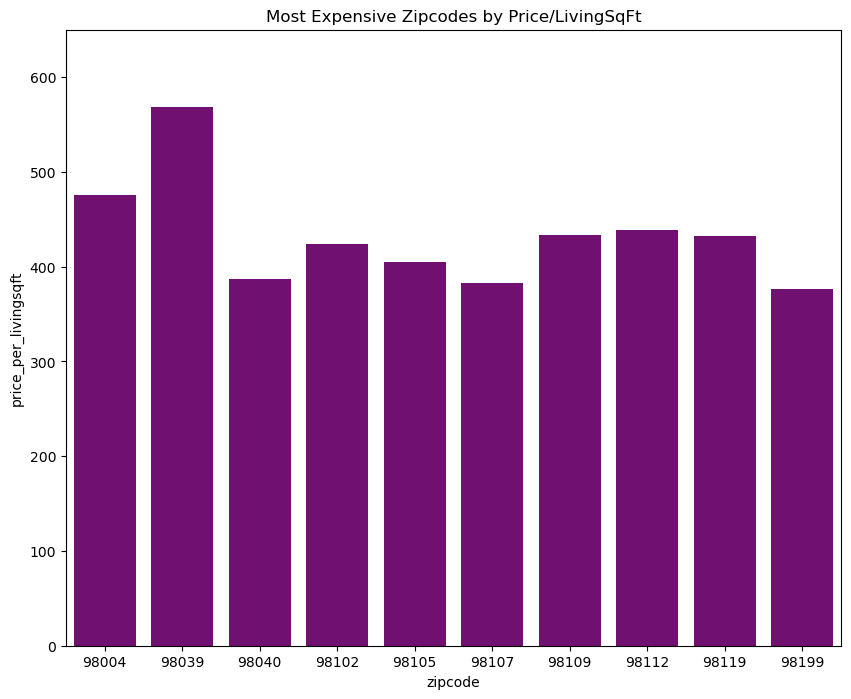

In [42]:
fig = plt.figure(figsize=(10,8))
sns.barplot(x='zipcode', y='price_per_livingsqft', data=top_df_livsq_ft_price,color= "purple")
plt.title('Most Expensive Zipcodes by Price/LivingSqFt')
plt.ylim(0,650)
plt.show()

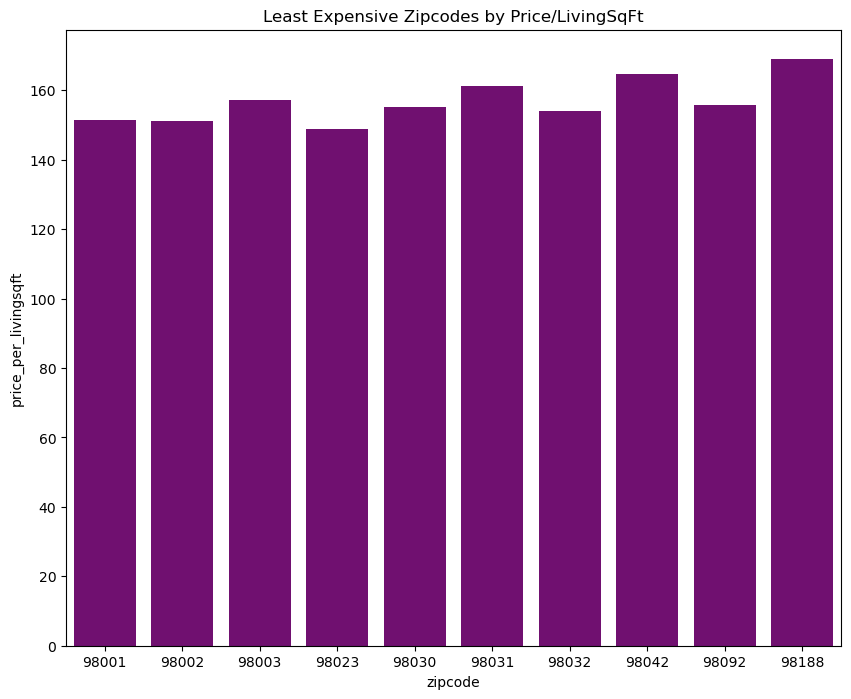

In [43]:
fig = plt.figure(figsize=(10,8))
sns.barplot(x='zipcode', y='price_per_livingsqft', data=bottom_df_livsq_ft_price, color ="purple")
plt.title('Least Expensive Zipcodes by Price/LivingSqFt')
plt.show()

In [44]:
bottom_df_livsq_ft_price

,zipcode,price_per_livingsqft
67,98188,169.007306
26,98042,164.589346
19,98031,161.101680
2,98003,157.113414
40,98092,155.830996
18,98030,155.156221
20,98032,154.098932
0,98001,151.362546
1,98002,151.174091
13,98023,148.844887


n conclusion, when we look at the correlation coefficients, the living square footage has a bigger impact on the price than the lot square footage (0.7 and 0.09 respectively).
The most expensive zipcodes in terms of living square footage price are similar to our findings from the first feature. However, none of them are waterfront and many of them are also the most expensive in terms of land price.


### LINEAR REGRESSION

In [76]:
# We create a model to test using the following features
import statsmodels.api as sm
from statsmodels.formula.api import ols

simple_formula = 'price ~ sqft_living + condition+ grade+ price + bedrooms + home_age'
simple_model = ols(simple_formula, df).fit()
simple_model_summary = simple_model.summary()

simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.391e+33
Date:                Fri, 19 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:36:07   Log-Likelihood:             4.4354e+05
No. Observations:               21533   AIC:                        -8.871e+05
Df Residuals:                   21526   BIC:                        -8.870e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.037e-10    2.3e-11     -8.868      0.000   -2.49e-10   -1.59e-10
sqft_living  3.109e-14   4.07e-15      7.633      0.000    2.31e-14    3.91e-14
condition    5.548e-11    3.1e-12     17.900      0.000    4.94e-11    6.16e-11
grade       -5.002e-12   2.88e-12     -1.736      0.083   -1.07e-11    6.46e-13
price           1.0000    8.2e-18   1.22e+17      0.000       1.000       1.000
bedrooms    -1.592e-12   2.63e-12     -0.604      0.546   -6.76e-12    3.57e-12
home_age     4.547e-13   8.08e-14      5.627      0.000    2.96e-13    6.13e-13
==============================================================================
Omnibus:                    22134.129   Durbin-Watson:                   0.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2433128.159
Skew:                           4.932   Prob(JB):                         0.00
Kurtosis:                      54.133   Cond. No.                     8.08e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
formula = 'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + yr_built + yr_renovated'
#Included everything about the house
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     3116.
Date:                Thu, 18 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:09:46   Log-Likelihood:            -2.9501e+05
No. Observations:               21533   AIC:                         5.900e+05
Df Residuals:                   21519   BIC:                         5.902e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.199e+06   1.37e+05     45.353      0.000    5.93e+06    6.47e+06
bedrooms      -4.267e+04   2117.110    -20.154      0.000   -4.68e+04   -3.85e+04
bathrooms       4.68e+04   3502.079     13.363      0.000    3.99e+04    5.37e+04
sqft_living     115.1330     19.359      5.947      0.000      77.189     153.077
sqft_lot         -0.2661      0.037     -7.269      0.000      -0.338      -0.194
floors         2.435e+04   3733.524      6.523      0.000     1.7e+04    3.17e+04
waterfront     5.835e+05   1.95e+04     29.918      0.000    5.45e+05    6.22e+05
view           4.673e+04   2233.247     20.926      0.000    4.24e+04    5.11e+04
condition      1.949e+04   2489.294      7.831      0.000    1.46e+04    2.44e+04
grade          1.247e+05   2170.572     57.442      0.000     1.2e+05    1.29e+05
sqft_above       56.1978     19.299      2.912      0.004      18.370      94.025
sqft_basement    57.8258     19.187      3.014      0.003      20.218      95.433
yr_built      -3571.6318     70.102    -50.949      0.000   -3709.037   -3434.227
yr_renovated     12.9288      4.254      3.040      0.002       4.592      21.266
==============================================================================
Omnibus:                    15798.112   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1053726.281
Skew:                           2.919   Prob(JB):                         0.00
Kurtosis:                      36.769   Cond. No.                     4.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared: 0.653

This indicates that approximately 65.3% of the variance in house prices (price) can be explained by the model. This suggests a moderately strong relationship between the predictors and the dependent variable (price).

Adj. R-squared: 0.653

Adjusted R-squared accounts for the number of predictors in the model. It's similar to the R-squared value, indicating that the model doesn't suffer much from overfitting.

F-statistic: 3116 with a Prob (F-statistic) of 0.00

This highly significant F-statistic (p < 0.05) suggests that the overall model is statistically significant and that at least some of the predictors are related to the dependent variable (price).



In [54]:
formula = 'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + home_age'
#dropped a few categories, no relevant change in the data
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     3373.
Date:                Thu, 18 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:09:46   Log-Likelihood:            -2.9501e+05
No. Observations:               21533   AIC:                         5.900e+05
Df Residuals:                   21520   BIC:                         5.902e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -9.992e+05   1.74e+04    -57.335      0.000   -1.03e+06   -9.65e+05
bedrooms      -4.285e+04   2116.712    -20.242      0.000    -4.7e+04   -3.87e+04
bathrooms      4.807e+04   3477.432     13.825      0.000    4.13e+04    5.49e+04
sqft_living     115.5074     19.362      5.966      0.000      77.557     153.458
sqft_lot         -0.2655      0.037     -7.252      0.000      -0.337      -0.194
floors         2.477e+04   3731.747      6.637      0.000    1.75e+04    3.21e+04
waterfront     5.861e+05   1.95e+04     30.076      0.000    5.48e+05    6.24e+05
view           4.686e+04   2233.271     20.984      0.000    4.25e+04    5.12e+04
condition      1.838e+04   2462.405      7.462      0.000    1.35e+04    2.32e+04
grade          1.248e+05   2170.827     57.473      0.000    1.21e+05    1.29e+05
sqft_above       55.7311     19.302      2.887      0.004      17.898      93.565
sqft_basement    57.3665     19.190      2.989      0.003      19.753      94.980
home_age       3633.0222     67.142     54.109      0.000    3501.418    3764.626
==============================================================================
Omnibus:                    15821.061   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1059353.867
Skew:                           2.924   Prob(JB):                         0.00
Kurtosis:                      36.860   Cond. No.                     5.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared: 0.653

This statistic indicates that approximately 65.3% of the variability in house prices is explained by the model. 

Adj. R-squared: 0.653

The adjusted R-squared for the number of predictors in the model relative to the number of data points, penalizes the R-squared value for adding variables that do not improve the model significantly. In this case, it is equal to the R-squared value, indicating that the model is not overfitted.

Prob (F-statistic): 0.00

A value of 0.00 means that the probability of observing such an F-statistic under the null hypothesis (that the model has no explanatory power) is zero. Meaning, the model is statistically significant.


In [55]:
formula1 = 'price ~ sqft_living'
#testing individuals to see how they correlate

liv_mod = ols(formula=formula1, data=df).fit()
liv_mod_sum = liv_mod.summary()

liv_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 2.087e+04
Date:                Thu, 18 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:09:47   Log-Likelihood:            -2.9911e+05
No. Observations:               21533   AIC:                         5.982e+05
Df Residuals:                   21531   BIC:                         5.982e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.218e+04   4404.621     -9.575      0.000   -5.08e+04   -3.35e+04
sqft_living   279.9379      1.938    144.475      0.000     276.140     283.736
==============================================================================
Omnibus:                    14581.827   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           516123.571
Skew:                           2.781   Prob(JB):                         0.00
Kurtosis:                      26.331   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared: 0.492

This indicates that 49.2% of the variability in house prices is explained by the model. This is moderate, given the statistic of the previous model.

Adj.R-squared: 0.492

Since there is only one predictor, the R-squared and adjusted R-squared are the same.

Prob (F-statistic): 0.00

Like the previous model, a value of 0.00 means that the probability of observing such an F-statistic under the null hypothesis (that the model has no explanatory power) is zero. Therefore, the model is statistically significant.

In [71]:
# group mean price and square footage by zipcode
zipcode_df = df[['zipcode', 'price','sqft_living']]
zipcode_df = zipcode_df.groupby(['zipcode']).mean().sort_values('price', ascending=False).round(2)

In [70]:
# fit model and print summary  
model_price_sqft = ols(formula='price ~ sqft_living', data=zipcode_df).fit() 
model_price_sqft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     95.67
Date:                Fri, 19 Jul 2024   Prob (F-statistic):           1.34e-14
Time:                        13:15:07   Log-Likelihood:                -951.37
No. Observations:                  70   AIC:                             1907.
Df Residuals:                      68   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.543e+05   1.16e+05     -4.763      0.000   -7.87e+05   -3.22e+05
sqft_living   531.3700     54.326      9.781      0.000     422.963     639.777
==============================================================================
Omnibus:                       11.543   Durbin-Watson:                   1.188
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.763
Skew:                           0.916   Prob(JB):                      0.00279
Kurtosis:                       3.822   Cond. No.                     1.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the 2 regression results above, it is clear that when sqft_living is grouped by zipcode, a higher percentage of the variance in house prices can be explained by the model (i.e.58.5% compared to 49.2%). 

The adjusted R-squared in this case adjusts down slightly to 57.8%, still indicating a good fit.

For the Prob (F-statistic), a value of 1.34e-14 means that the model is statistically significant.

In [56]:
formula2 = 'price ~ bathrooms'

bath_mod = ols(formula=formula2, data=df).fit()
bath_mod_sum = bath_mod.summary()

bath_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     8195.
Date:                Thu, 18 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:09:47   Log-Likelihood:            -3.0293e+05
No. Observations:               21533   AIC:                         6.059e+05
Df Residuals:                   21531   BIC:                         6.059e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.097e+04   6218.123      1.764      0.078   -1216.725    2.32e+04
bathrooms   2.501e+05   2762.368     90.528      0.000    2.45e+05    2.55e+05
==============================================================================
Omnibus:                    17083.526   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           857769.127
Skew:                           3.422   Prob(JB):                         0.00
Kurtosis:                      33.153   Cond. No.                         7.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared: 0.276

This indicates that 27.6% of the variability in house prices is explained by the number of bathrooms. This is a relatively low explanatory power, meaning other factors also significantly influence house prices.

Adj. R-squared: 0.276

The adjusted R-squared is the same as the R-squared, indicating no adjustments were necessary since there is only one predictor.


In [57]:
formula3 = 'price ~ bedrooms'

bed_mod = ols(formula=formula3, data=df).fit()
bed_mod_sum = bed_mod.summary()

bed_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     2376.
Date:                Thu, 18 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:09:47   Log-Likelihood:            -3.0528e+05
No. Observations:               21533   AIC:                         6.106e+05
Df Residuals:                   21531   BIC:                         6.106e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.097e+05   9140.676     12.005      0.000    9.18e+04    1.28e+05
bedrooms    1.276e+05   2618.516     48.741      0.000    1.22e+05    1.33e+05
==============================================================================
Omnibus:                    18717.690   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1129320.261
Skew:                           3.900   Prob(JB):                         0.00
Kurtosis:                      37.610   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Just like the previous regression model, the variability in house prices explained by the number of bathrooms has a relatively low explanatory power (9.9%), meaning other factors also significantly influence house prices.

In [72]:
# new home age feature with the assumption that its 2015 (this is because 2015 is the year with the most sold dates)
df['home_age'] = df['yr_built'].apply(lambda x: 2015 - x)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_lotsqft,price_per_livingsqft,home_age
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1955,0.0,98178,47.5112,-122.257,1340,5650,39.274336,188.050847,60
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,74.288870,209.338521,64
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,1933,0.0,98028,47.7379,-122.233,2720,8062,18.000000,233.766234,82
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1965,0.0,98136,47.5208,-122.393,1360,5000,120.800000,308.163265,50
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1987,0.0,98074,47.6168,-122.045,1800,7503,63.118812,303.571429,28


In [58]:
formula4 = 'price ~ home_age'

bed_mod = ols(formula=formula4, data=df).fit()
bed_mod_sum = bed_mod.summary()

bed_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     63.64
Date:                Thu, 18 Jul 2024   Prob (F-statistic):           1.57e-15
Time:                        21:09:47   Log-Likelihood:            -3.0637e+05
No. Observations:               21533   AIC:                         6.127e+05
Df Residuals:                   21531   BIC:                         6.128e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.698e+05   4486.049    127.019      0.000    5.61e+05    5.79e+05
home_age    -676.4560     84.799     -7.977      0.000    -842.669    -510.243
==============================================================================
Omnibus:                    18908.707   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1096402.227
Skew:                           3.983   Prob(JB):                         0.00
Kurtosis:                      37.038   Cond. No.                         95.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This regression model also has a relatively low explanatory power (0.3%), meaning that only 0.3% of the variance in house prices is affected by the age of the home.